# Twitter - Stream Tweets and Text Analytics

## A. Stream Tweets

#### Import Libraries

In [1]:
# Import Libraries
from twitter import *
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
##
import csv
from datetime import datetime
import time
from requests.exceptions import Timeout, ConnectionError
from requests.packages.urllib3.exceptions import ReadTimeoutError
##
import ssl
## Preprocessing
import pandas as pd
import re
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
set(stopwords.words('english'))
from wordcloud import WordCloud
## Plt
import matplotlib.pyplot as plt

#### Initialize Twitter API

In [2]:
# initialize api instance
consumer_key='7********************'
consumer_secret='w************************'
access_token='9****************************'
access_token_secret ='I**************************'

#Connect to Twitter through the API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
auth.set_access_token(access_token, access_token_secret) 
api = tweepy.API(auth,wait_on_rate_limit=True) 

#### Creating a StreamListener

In [3]:
class MyStreamListener(tweepy.StreamListener):
    def __init__(self):
        self.api = api
        self.me = api.me()
    def on_status(self, status):
        try:
            # saves the tweet object
            tweet_object = status

            #Checks if its a extended tweet (>140 characters)
            if 'extended_tweet' in tweet_object._json:
                tweet = tweet_object.extended_tweet['full_text']
            else:
                tweet = tweet_object.text
            
           # Save the keyword that matches the stream
            keyword_matches = []
            for word in keywords:
                if word.lower() in tweet.lower():
                    keyword_matches.extend([word])

            keywords_strings = ", ".join(str(x) for x in keyword_matches)
            
            # Save other information from the tweet
            user = status.author.screen_name
            location = status.user.location
            timeTweet = status.created_at
            source = status.source
        
            # Saves the tweet information in a new row of the CSV file
            writer.writerow([tweet, keywords_strings, timeTweet,user,location,source])
        
        except Exception as e:
            print('Encountered Exception:', e)
            pass
    
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            print("on_error: disconnect the stream")
            return False

#### Start Streaming

In [4]:
def start_streaming():
     # Opening a CSV file to save the gathered tweets
        with open(filename+".csv", 'w') as file:
            global writer
            writer = csv.writer(file)

            # Add a header row to the CSV
            writer.writerow(["Tweet", "Matched Keywords", "Date", "User","location","Source"])

            # Creating a Stream
            try:
                streamingAPI = tweepy.streaming.Stream(auth, MyStreamListener())
                #Starting a Stream
                streamingAPI.filter(track=keywords,languages=['en'])  
                #streamingAPI.filter(locations=LOCATIONS)
                
            except KeyboardInterrupt:
                #User pressed ctrl+c or cmd+c -- get ready to exit the program
                print("%s - KeyboardInterrupt caught. Closing stream and exiting."%datetime.now())
                #streamingAPI.close()
                streamingAPI.disconnect()
                pass
            # Stop temporarily when hitting Twitter rate Limit
            except tweepy.RateLimitError:
                print("RateLimitError...waiting ~15 minutes to continue")
                time.sleep(900)
                streamingAPI = tweepy.streaming.Stream(auth, MyStreamListener())
                streamingAPI.filter(track=keywords,languages=['en'])

            # Stop temporarily when getting a timeout or connection error
            except (Timeout, ssl.SSLError, ReadTimeoutError,ConnectionError) as exc:
                print("Timeout/connection error...waiting ~15 minutes to continue")
                time.sleep(900)
                streamingAPI = tweepy.streaming.Stream(auth, MyStreamListener())
                streamingAPI.filter(track=keywords,languages=['en'])
            # Stop temporarily when getting other errors
            except tweepy.TweepError as e:
                if 'Failed to send request:' in e.reason:
                    print("Time out error caught.")
                    time.sleep(900)
                    streamingAPI = tweepy.streaming.Stream(auth, MyStreamListener())
                    streamingAPI.filter(track=keywords,languages=['en'])
                else:
                    print("Other error with this user...passing")
                    pass
            

In [5]:
if __name__ == '__main__':
    # Setting up the keywords, hashtag or mentions we want to listen
    keywords = ['#IndiaFightsCorona', '#IndiaSpreadingCovidRacism', '#lockdownindia', '#coronavirusinindia']
    filename = "tweets"
   ### Call Function to start streaming
    start_streaming()
    

2020-04-21 10:28:16.666381 - KeyboardInterrupt caught. Closing stream and exiting.


## B. Text Analytics

#### Reading Tweets

In [12]:
df_tweets = pd.read_csv("tweets_1.csv")
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 6 columns):
Tweet               5945 non-null object
Matched Keywords    2126 non-null object
Date                5945 non-null object
User                5945 non-null object
location            4257 non-null object
Source              5945 non-null object
dtypes: object(6)
memory usage: 278.8+ KB


In [13]:
df_tweets.head()

,Tweet,Matched Keywords,Date,User,location,Source
0,RT @MoHFW_INDIA: #IndiaFightsCorona:\n\nInform...,#IndiaFightsCorona,2020-04-17 17:19:20,genius_wasted,Odisha,Twitter Web App
1,RT @IndiaToday: UP sends 300 buses to rescue s...,NaN,2020-04-17 17:19:21,anthonyjos,NaN,Twitter for Android
2,RT @Tamilthangam22: @TamilTheHindu #Coronaoutb...,NaN,2020-04-17 17:19:21,MNARENDRAKUMAR2,"Tamil Nadu, India",Twitter for Android
3,RT @mannkibaat: Where 130 crore hearts beat to...,#IndiaFightsCorona,2020-04-17 17:19:21,DarshanGor1722,"Bhuj, India",Twitter for Android
4,RT @mygovindia: Lockdown 2.0: Guidelines every...,#IndiaFightsCorona,2020-04-17 17:19:21,HarshwardhnT,"Mumbai, India",Twitter Web App


#### Clean the Tweets

In [8]:
def clean_tweets(tweets,Mystopwords):
    try:
        # Preprocessing
        clean_tweets = ' '.join(tweets)
        # convert to lower case
        clean_tweets =  clean_tweets.lower()
        # remove URLs
        clean_tweets = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', clean_tweets) 
        # remove the # in #hashtag
        clean_tweets = re.sub(r'#([^\s]+)', r'\1', clean_tweets) 
        # remove usernames
        clean_tweets = re.sub('@[^\s]+', 'AT_USER', clean_tweets)
        #replace consecutive non-ASCII characters with a space
        clean_tweets = re.sub(r'[^\x00-\x7F]+',' ', clean_tweets)
        # remove punctuation
        clean_tweets = re.sub(r'[^\w\s]', '', clean_tweets)
        # remove emojis
        clean_tweets = clean_tweets.encode('ascii', 'ignore').decode('ascii')
        # remove trailing spaces
        clean_tweets = clean_tweets.strip()
        # remove numbers
        clean_tweets = re.sub('[0-9]+', '', clean_tweets)
        # tokenize 
        clean_tweets = word_tokenize(clean_tweets)
        # remove stop words
        stop = stopwords.words('english')
        stop.extend(Mystopwords)
        clean_tweets = [w for w in clean_tweets if not w in stop] 
        
        return clean_tweets
    except:
        print("In Exception")
        return None

In [14]:
Mystopwords = ["AT_USER","URL","rt","india","indiafightscorona","corona","coronavirus","coronavirusinindia","lockdown","covid","_","amp","ji","one","people","see"]
corpus = clean_tweets(df_tweets.Tweet,Mystopwords)

#### Get Frequency Distribution

In [15]:
import operator # To sort dictionary values
# join the words in string
words = ' '.join(corpus)
words = words.split()
#print(words)
# create a empty dictionary
data = dict()
#  Get frequency for each words where word is the key and the count is the value
for word in (words):
    word = word.lower()
    data[word] = data.get(word, 0) + 1
# Sort the dictionary in reverse order to print first the most used terms    
dict(sorted(data.items(), key=operator.itemgetter(1),reverse=True))

{'help': 472,
 'covid_': 393,
 'times': 265,
 'country': 251,
 'dear': 242,
 'way': 231,
 'republic': 227,
 'grateful': 225,
 'challenging': 223,
 'ambassador': 222,
 'dominican': 221,
 'rs': 219,
 'pm': 194,
 'little': 192,
 'medicine': 190,
 'please': 189,
 'goes': 188,
 'long': 183,
 'govt': 179,
 'retweet': 159,
 'another': 154,
 'without': 136,
 'april': 130,
 'around': 130,
 'fight': 128,
 'different': 125,
 'woman': 122,
 'ghee': 121,
 'indian': 121,
 'rupees': 120,
 'govardhan': 120,
 'kitchen': 119,
 'costs': 118,
 'apparently': 117,
 'wouldnt': 117,
 'survive': 117,
 'alone': 117,
 'c': 117,
 'public': 112,
 'modi': 111,
 'app': 110,
 'use': 108,
 'stayhome': 107,
 'institute': 106,
 'medical': 102,
 'th': 96,
 'information': 88,
 'aid': 86,
 'police': 86,
 'covidindia': 83,
 'period': 82,
 'necessary': 80,
 'relief': 80,
 'time': 80,
 'workers': 79,
 'minister': 79,
 'sri': 79,
 'cm': 76,
 'medicines': 75,
 'stayhomestaysafe': 75,
 'yojana': 75,
 'general': 74,
 'availabilit

#### Create a WordCloud

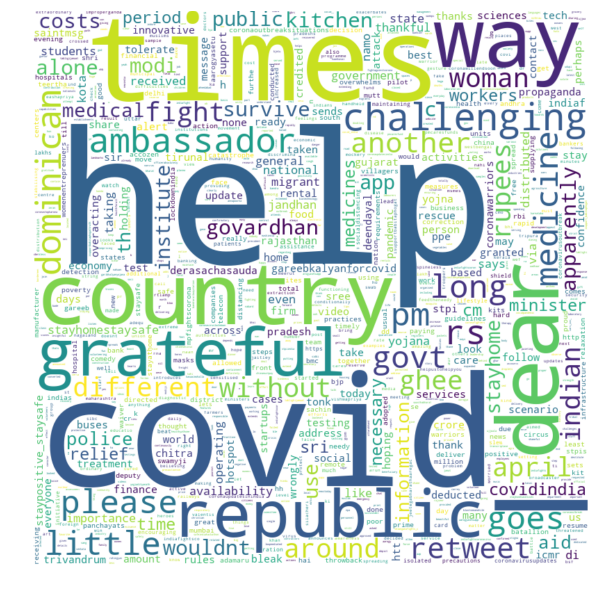

In [16]:
word_cloud = WordCloud(width = 800, height = 800, background_color ='white',max_words = 1000)
word_cloud.generate_from_frequencies(data)
# plot the WordCloud image                        
plt.figure(figsize = (10, 8), edgecolor = 'k') 
plt.imshow(word_cloud,interpolation = 'bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()